# Introduction of the project

1. Project Name: Carpark Occupany Prediction Regression
2. Deliverable: Trained Model File
3. Machine Learning Task: Regression
3. Target Variable: Daily_cars
4. Input Features: See Data Dictionary
6. Win Condition: N/A (Best Possible Model)

In Summary:

This topic of the project is to predict the carpark occupancy in the current company. By consider the employement growth rate, we need to ensure company facilities able to cater the need especially on the carpark. By predict the potential car park occupancy can convince management to allocate the budget before the congestion happened.

## 0.0 Library Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

## Pickle for saving model files
import pickle

## Import Regularized Regression Algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet

## Import Tree Ensemble Algos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Function for splitting training and test set
from sklearn.model_selection import train_test_split

## Function for creating model pipelines
from sklearn.pipeline import make_pipeline

## StandardScaler
from sklearn.preprocessing import StandardScaler

## GridSearchCV
from sklearn.model_selection import GridSearchCV

## Performance metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

## 1.0 Exploratory Analysis

### 1.0 Basic Informations

In [2]:
df = pd.read_csv("carpark_data.csv", parse_dates=["Date"])

df.head()

,Date,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Daily_cars
0,2021-11-23,767,263,88.5,78.0,81.5,104.1,0,11.0,110.26,4.8,42.3,87.09,Partially cloudy,662
1,2021-11-24,761,266,89.6,76.3,82.8,100.7,0,9.7,133.13,5.3,40.7,80.42,Partially cloudy,669
2,2021-11-25,733,273,87.1,76.8,81.3,97.9,0,7.6,145.67,4.7,49.0,84.02,Partially cloudy,674
3,2021-11-26,722,277,85.3,77.0,81.0,97.2,0,8.1,101.43,5.2,41.8,84.76,Partially cloudy,634
4,2021-11-27,44,78,87.9,77.0,82.0,100.1,0,7.7,118.73,5.3,40.1,81.24,Partially cloudy,610


In [3]:
df.shape

(69, 15)

In [4]:
df.dtypes

Date                   datetime64[ns]
ViTroxian                       int64
Subcon                          int64
Maximum Temperature           float64
Minimum Temperature           float64
Temperature                   float64
Heat Index                    float64
Precipitation                   int64
Wind Speed                    float64
Wind Direction                float64
Visibility                    float64
Cloud Cover                   float64
Relative Humidity             float64
Conditions                     object
Daily_cars                      int64
dtype: object

In [5]:
df["Conditions"].unique()

array(['Partially cloudy'], dtype=object)

We may drop df["Conditions"] category variable as only have one unique value that wont contribute much on the prediction.

### 1.2 Distributions of Numeric Features

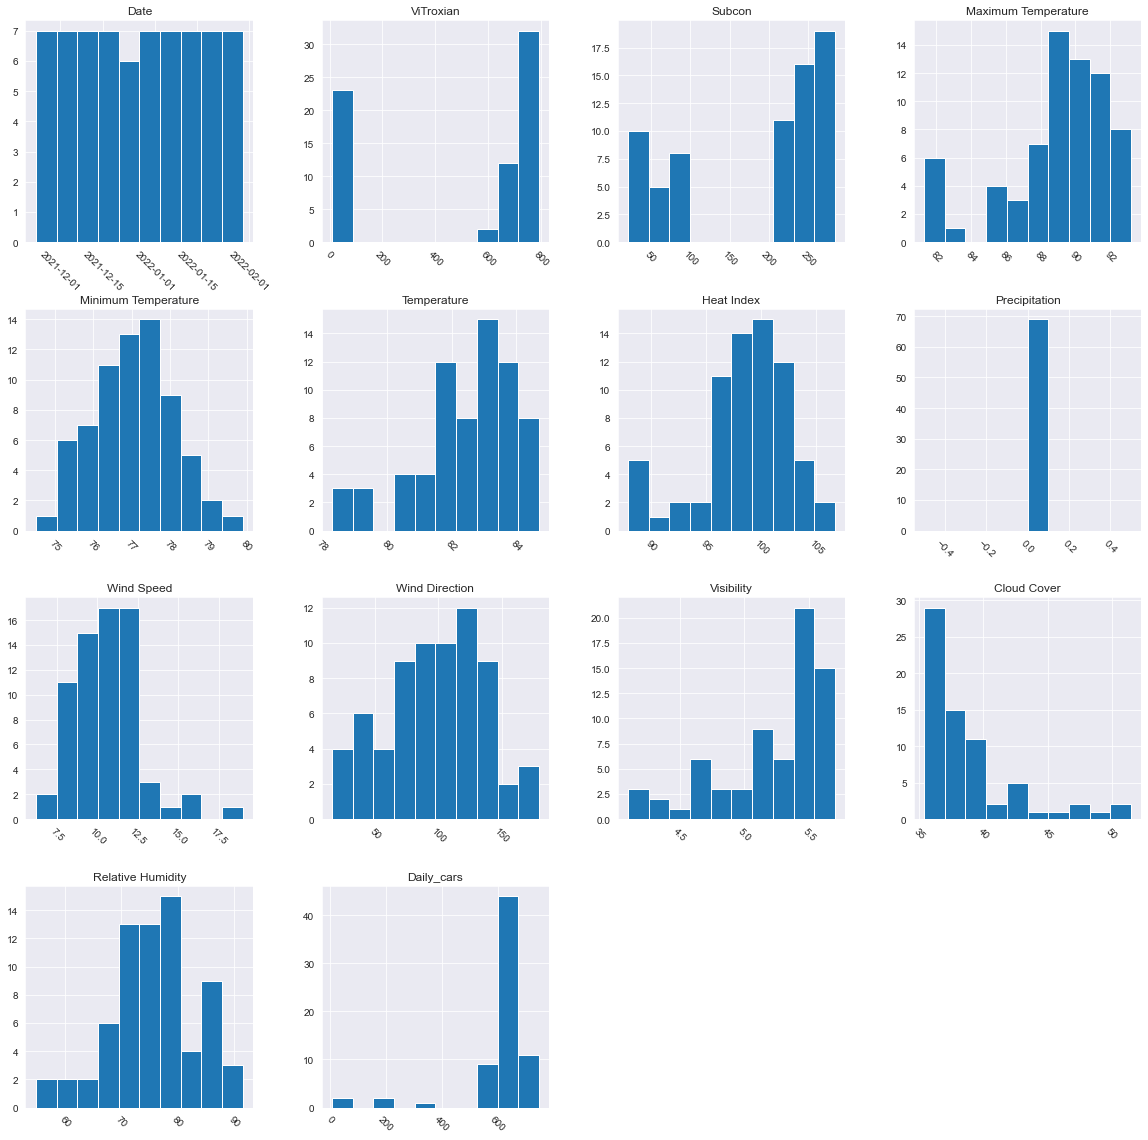

In [6]:
df.hist(figsize=(20,20), xrot=-45)

plt.show()

In [7]:
df.describe()

,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Daily_cars
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.0,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,499.695652,184.782609,88.992754,77.007246,82.433333,98.598551,0.0,10.565217,97.301159,5.221739,38.878261,75.781884,602.710145
std,336.226303,94.264626,2.973279,1.112406,1.561077,4.170220,0.0,2.127607,38.844489,0.418284,3.731459,7.664203,139.612500
min,9.000000,21.000000,81.300000,74.500000,78.300000,87.900000,0.0,6.200000,15.910000,4.100000,35.400000,54.800000,7.000000
25%,44.000000,79.000000,87.900000,76.300000,81.700000,96.800000,0.0,9.200000,72.330000,5.000000,36.100000,71.090000,605.000000
50%,708.000000,234.000000,89.600000,77.000000,82.800000,99.100000,0.0,10.600000,101.430000,5.400000,37.500000,75.780000,634.000000
75%,756.000000,262.000000,91.200000,77.500000,83.500000,101.300000,0.0,11.700000,124.420000,5.500000,40.000000,80.420000,662.000000
max,791.000000,284.000000,93.200000,79.900000,84.700000,106.700000,0.0,19.000000,179.430000,5.700000,51.500000,91.570000,747.000000


**Check & Answer**

1. Do each of the distributions make intuitive sense to you? **Maybe, we need to check on "ViTroxians", "Subcons" & Daiy_car"**
2. Do you anticapte any issue or sparse data? **No**
3. Are they any surprising distributions you should take a closer look at? **No**
4. Do the summary statistics confirm what you've seen from the charts? **Yes**

**For the inconsitent value of "ViTroxians". "Subcons" and "Daily_car" may caused by the weekend and weekday. In generally, weekend will have much less people coming to work hence the quantity of daily cars will be reduced. At the same time, we may removed "Precipitation" from the dataset as that is not much contribution"**

### 1.3 Distributions of Categorical Features

In [8]:
df.describe(include=["object"])

,Conditions
count,69
unique,1
top,Partially cloudy
freq,69


Instead of removing "Date", we can actually convert the date to the name of weekday and create another categorical feature. The reason we did this is because we need to cater the weekend with less car.

In [9]:
def date_to_weekday(x):
    return x.strftime('%A')

df["Weekday"] = df["Date"].apply(date_to_weekday)

In [10]:
## Quick check on the "Weekday" feature
df.head()

,Date,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Daily_cars,Weekday
0,2021-11-23,767,263,88.5,78.0,81.5,104.1,0,11.0,110.26,4.8,42.3,87.09,Partially cloudy,662,Tuesday
1,2021-11-24,761,266,89.6,76.3,82.8,100.7,0,9.7,133.13,5.3,40.7,80.42,Partially cloudy,669,Wednesday
2,2021-11-25,733,273,87.1,76.8,81.3,97.9,0,7.6,145.67,4.7,49.0,84.02,Partially cloudy,674,Thursday
3,2021-11-26,722,277,85.3,77.0,81.0,97.2,0,8.1,101.43,5.2,41.8,84.76,Partially cloudy,634,Friday
4,2021-11-27,44,78,87.9,77.0,82.0,100.1,0,7.7,118.73,5.3,40.1,81.24,Partially cloudy,610,Saturday


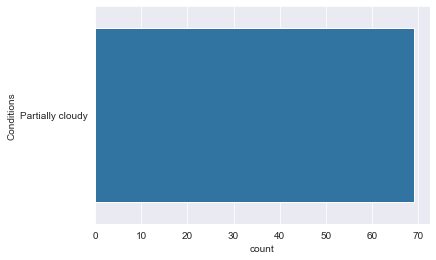

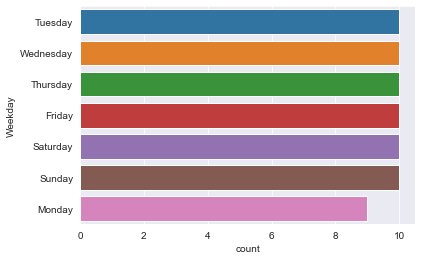

In [11]:
for feature in df.dtypes[df.dtypes == "object"].index:
    sns.countplot(y=feature, data=df)
    plt.show()

**Check & Answer**

1. Are there any classess that might be sparse? No
2. Are there any classess that shouldn't be in dataset based on our project scope? **Yes,we can remove "Date" and "Conditions"**
3. Are there any mislabeled classes? No
4. Are the distributions seem intuitive? Yes

### 1.4 Segmentation

In [12]:
df.head()

,Date,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Daily_cars,Weekday
0,2021-11-23,767,263,88.5,78.0,81.5,104.1,0,11.0,110.26,4.8,42.3,87.09,Partially cloudy,662,Tuesday
1,2021-11-24,761,266,89.6,76.3,82.8,100.7,0,9.7,133.13,5.3,40.7,80.42,Partially cloudy,669,Wednesday
2,2021-11-25,733,273,87.1,76.8,81.3,97.9,0,7.6,145.67,4.7,49.0,84.02,Partially cloudy,674,Thursday
3,2021-11-26,722,277,85.3,77.0,81.0,97.2,0,8.1,101.43,5.2,41.8,84.76,Partially cloudy,634,Friday
4,2021-11-27,44,78,87.9,77.0,82.0,100.1,0,7.7,118.73,5.3,40.1,81.24,Partially cloudy,610,Saturday


In [13]:
print(df.dtypes[df.dtypes != "object"].drop(["Date", "Precipitation"]))

ViTroxian                int64
Subcon                   int64
Maximum Temperature    float64
Minimum Temperature    float64
Temperature            float64
Heat Index             float64
Wind Speed             float64
Wind Direction         float64
Visibility             float64
Cloud Cover            float64
Relative Humidity      float64
Daily_cars               int64
dtype: object


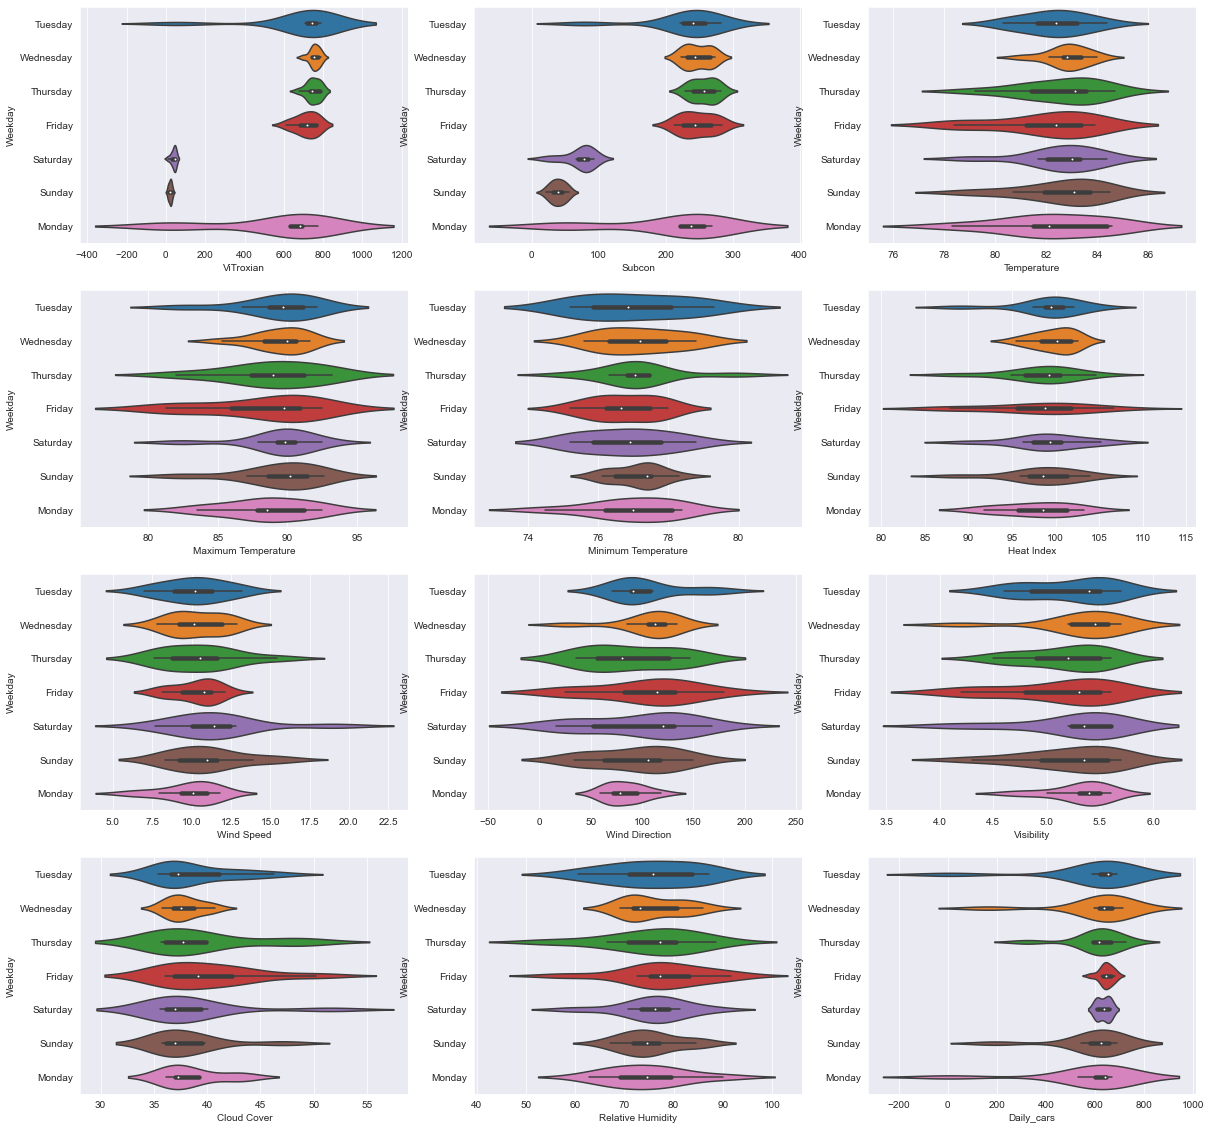

In [14]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

### Row 1
sns.violinplot(x='ViTroxian', y='Weekday', data=df, ax=axs[0][0], scale="count")
sns.violinplot(x='Subcon', y='Weekday', data=df, ax=axs[0][1], scale="count")
sns.violinplot(x='Temperature',y='Weekday', data=df, ax=axs[0][2], scale="count")

### Row 2
sns.violinplot(x='Maximum Temperature', y='Weekday', data=df, ax=axs[1][0], scale="count")
sns.violinplot(x='Minimum Temperature', y='Weekday', data=df, ax=axs[1][1], scale="count")
sns.violinplot(x='Heat Index',y='Weekday', data=df, ax=axs[1][2])

### Row 3
sns.violinplot(x='Wind Speed', y='Weekday', data=df, ax=axs[2][0], scale="count")
sns.violinplot(x='Wind Direction', y='Weekday', data=df, ax=axs[2][1], scale="count")
sns.violinplot(x='Visibility',y='Weekday', data=df, ax=axs[2][2], scale="count")

### Row 4
sns.violinplot(x='Cloud Cover', y='Weekday', data=df, ax=axs[3][0], scale="count")
sns.violinplot(x='Relative Humidity', y='Weekday', data=df, ax=axs[3][1], scale="count")
sns.violinplot(x='Daily_cars',y='Weekday', data=df, ax=axs[3][2], scale="count")

plt.show()

In [15]:
df.groupby("Weekday").mean()

,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Daily_cars
Weekday,,,,,,,,,,,,,
Friday,712.900000,247.100000,88.150000,76.750000,81.910000,97.720000,0.0,10.270000,104.014000,5.10,40.24,77.723000,643.900000
Monday,547.333333,203.444444,88.511111,76.966667,82.211111,97.811111,0.0,9.811111,83.524444,5.30,38.60,74.581111,557.555556
Saturday,38.200000,71.100000,89.300000,76.820000,82.590000,99.070000,0.0,11.650000,98.242000,5.23,38.73,75.776000,633.900000
Sunday,21.300000,38.900000,89.400000,77.130000,82.580000,98.390000,0.0,11.060000,93.996000,5.22,38.30,75.324000,584.400000
Thursday,748.400000,257.000000,88.890000,77.150000,82.550000,98.220000,0.0,10.520000,88.866000,5.17,39.55,75.338000,603.700000
Tuesday,678.400000,230.500000,89.250000,77.040000,82.340000,99.080000,0.0,10.190000,105.014000,5.22,38.85,75.570000,583.900000
Wednesday,756.100000,247.300000,89.400000,77.190000,82.830000,99.820000,0.0,10.380000,106.074000,5.32,37.85,76.041000,607.100000


** Interest Fact: Monday, Saturday, Sunday has the lowest employees and the car park usage.**

### 1.5 Correlations

In [16]:
correlations = df.drop(["Precipitation"], axis=1).corr()

In [17]:
correlations

,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Daily_cars
ViTroxian,1.000000,0.978129,-0.082263,-0.054863,-0.088262,0.009350,-0.250850,0.076164,-0.047069,0.080004,0.092962,-0.089393
Subcon,0.978129,1.000000,-0.122113,-0.067455,-0.130565,0.000123,-0.296659,0.088941,-0.119937,0.142014,0.144985,-0.034946
Maximum Temperature,-0.082263,-0.122113,1.000000,0.216503,0.931512,0.769627,0.407802,0.075584,0.410913,-0.754722,-0.793332,-0.305405
Minimum Temperature,-0.054863,-0.067455,0.216503,1.000000,0.376535,0.238455,0.289781,-0.187195,-0.037321,0.008541,-0.138163,-0.045248
Temperature,-0.088262,-0.130565,0.931512,0.376535,1.000000,0.780251,0.412128,0.103218,0.333992,-0.723265,-0.742682,-0.251535
Heat Index,0.009350,0.000123,0.769627,0.238455,0.780251,1.000000,0.128331,0.284507,0.033235,-0.587831,-0.280317,-0.041324
Wind Speed,-0.250850,-0.296659,0.407802,0.289781,0.412128,0.128331,1.000000,-0.489713,0.375968,-0.278818,-0.482583,-0.138370
Wind Direction,0.076164,0.088941,0.075584,-0.187195,0.103218,0.284507,-0.489713,1.000000,-0.264197,-0.041631,0.145374,0.050697
Visibility,-0.047069,-0.119937,0.410913,-0.037321,0.333992,0.033235,0.375968,-0.264197,1.000000,-0.433762,-0.605228,-0.245770
Cloud Cover,0.080004,0.142014,-0.754722,0.008541,-0.723265,-0.587831,-0.278818,-0.041631,-0.433762,1.000000,0.677677,0.215219


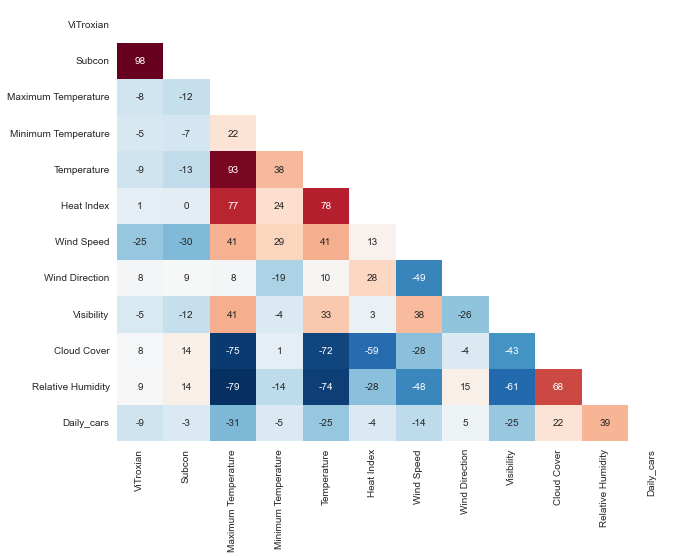

In [18]:
## White background Chart
sns.set_style("whitegrid")

## Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(10,8))

sns.heatmap(correlations * 100, 
            cmap="RdBu_r", 
            annot=True, 
            fmt=".0f", 
            mask=mask,
            cbar=False
           )

plt.show()

* Temperature and Minimum Temperature -> Strong Positive Correlation
* Heat Index and Maximum Temperature -> Strong Positive Correlation
* Heat Index and Tempearature -> Strong Positive Correlation
* Cloud Cover and Maximum Temperature -> Stong Negative Correlation
* Cloud Cover and Minimum Temperature -> Strong Negative Correlation
* Relative Humidity and Maximum Temperature -> Strong Negative Correlation
* Relative Humidity and Temperature -> Strong Negative Correlation

** We may need to drop either one in the feature engineering selection, as strong correlation between 2 variables lead to similar pattern and knowledge significantly reduce the performance

## 2.0 Data Cleaning

In [18]:
df.head()

,Date,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Daily_cars,Weekday
0,2021-11-23,767,263,88.5,78.0,81.5,104.1,0,11.0,110.26,4.8,42.3,87.09,Partially cloudy,662,Tuesday
1,2021-11-24,761,266,89.6,76.3,82.8,100.7,0,9.7,133.13,5.3,40.7,80.42,Partially cloudy,669,Wednesday
2,2021-11-25,733,273,87.1,76.8,81.3,97.9,0,7.6,145.67,4.7,49.0,84.02,Partially cloudy,674,Thursday
3,2021-11-26,722,277,85.3,77.0,81.0,97.2,0,8.1,101.43,5.2,41.8,84.76,Partially cloudy,634,Friday
4,2021-11-27,44,78,87.9,77.0,82.0,100.1,0,7.7,118.73,5.3,40.1,81.24,Partially cloudy,610,Saturday


### 2.1 Drop Unwanted Observations

In [19]:
## Before drop duplicates
df.shape

(69, 16)

In [20]:
df = df.drop_duplicates()

df.shape

(69, 16)

We can conclude that is no duplicate observations in this dataset

### 2.2 Fix Structural Errors

In [21]:
df.head()

,Date,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Daily_cars,Weekday
0,2021-11-23,767,263,88.5,78.0,81.5,104.1,0,11.0,110.26,4.8,42.3,87.09,Partially cloudy,662,Tuesday
1,2021-11-24,761,266,89.6,76.3,82.8,100.7,0,9.7,133.13,5.3,40.7,80.42,Partially cloudy,669,Wednesday
2,2021-11-25,733,273,87.1,76.8,81.3,97.9,0,7.6,145.67,4.7,49.0,84.02,Partially cloudy,674,Thursday
3,2021-11-26,722,277,85.3,77.0,81.0,97.2,0,8.1,101.43,5.2,41.8,84.76,Partially cloudy,634,Friday
4,2021-11-27,44,78,87.9,77.0,82.0,100.1,0,7.7,118.73,5.3,40.1,81.24,Partially cloudy,610,Saturday


In [22]:
df.isnull().sum()

Date                   0
ViTroxian              0
Subcon                 0
Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Heat Index             0
Precipitation          0
Wind Speed             0
Wind Direction         0
Visibility             0
Cloud Cover            0
Relative Humidity      0
Conditions             0
Daily_cars             0
Weekday                0
dtype: int64

There is no any null values in the dataset

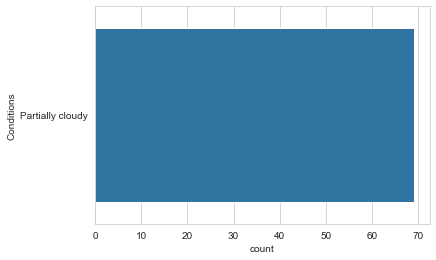

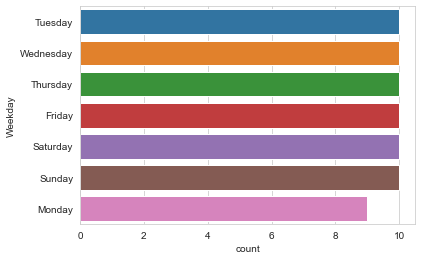

In [24]:
## Quick look on any typos of inconsistent capitalization
for feature in df.dtypes[df.dtypes == "object"].index:
    sns.countplot(y=feature, data=df)
    plt.show()

Seem likes there isn't any typos or inconsistent capitalization in the dataset

### 2.0 Remove "Guilty Outlier"

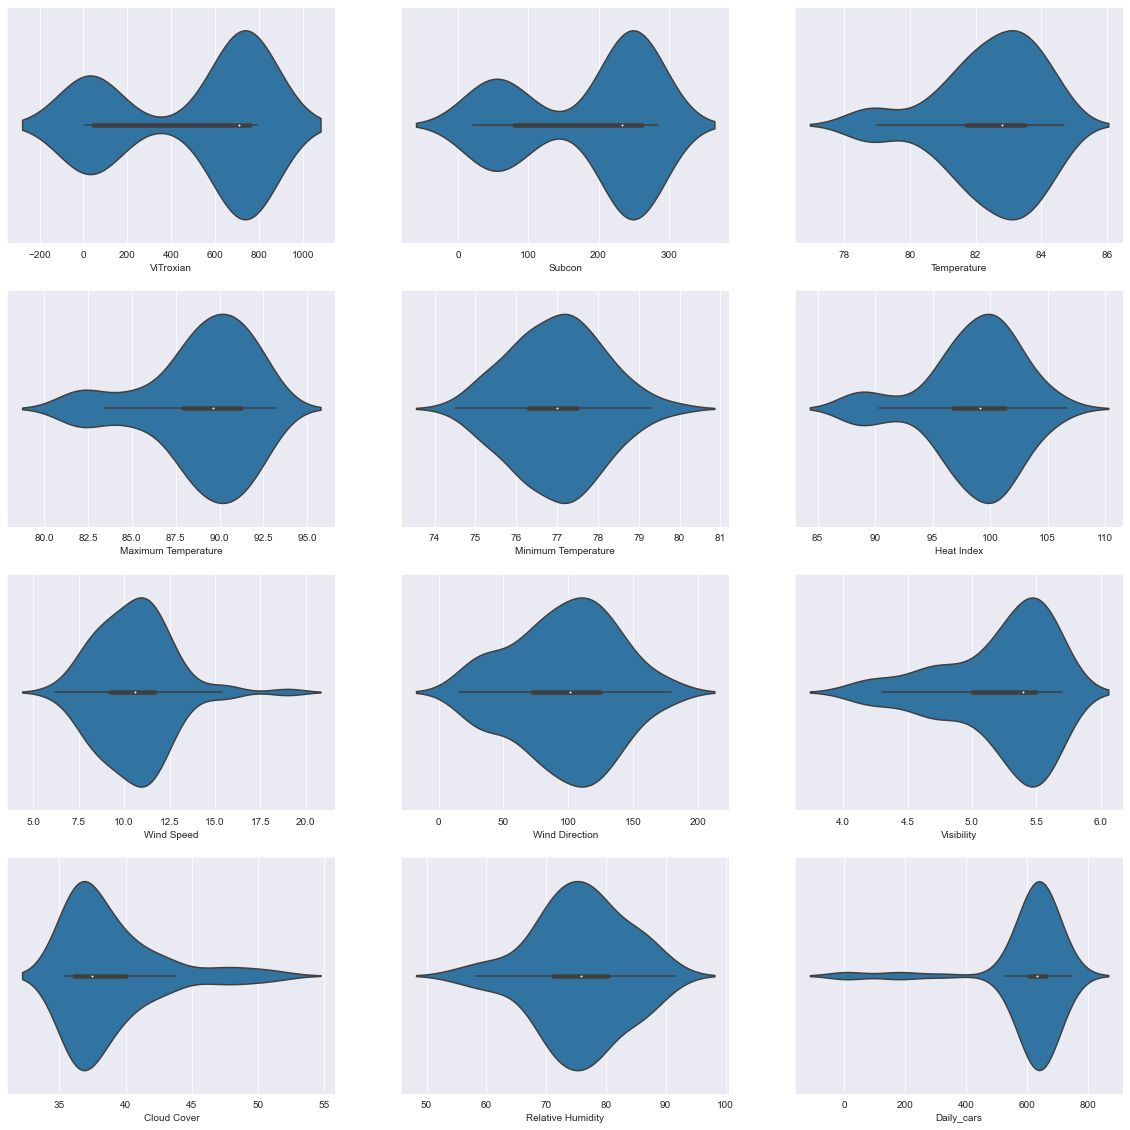

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

### Row 1
sns.violinplot(x="ViTroxian", data=df, ax=axs[0][0], scale="count")
sns.violinplot(x="Subcon", data=df, ax=axs[0][1], scale="count")
sns.violinplot(x="Temperature", data=df, ax=axs[0][2], scale="count")

### Row 2
sns.violinplot(x="Maximum Temperature", data=df, ax=axs[1][0], scale="count")
sns.violinplot(x="Minimum Temperature", data=df, ax=axs[1][1], scale="count")
sns.violinplot(x="Heat Index", data=df, ax=axs[1][2])

### Row 3
sns.violinplot(x="Wind Speed", data=df, ax=axs[2][0], scale="count")
sns.violinplot(x="Wind Direction", data=df, ax=axs[2][1], scale="count")
sns.violinplot(x="Visibility", data=df, ax=axs[2][2], scale="count")

### Row 4
sns.violinplot(x="Cloud Cover", data=df, ax=axs[3][0], scale="count")
sns.violinplot(x="Relative Humidity", data=df, ax=axs[3][1], scale="count")
sns.violinplot(x="Daily_cars", data=df, ax=axs[3][2], scale="count")

plt.show()

Among those features, it look like there is nothing really stands out as possible outlier.

### 2.4 Handle Missing Data

In [24]:
## Quick look on any missing data in numeric features
df.select_dtypes(exclude=["object"]).isnull().sum()

Date                   0
ViTroxian              0
Subcon                 0
Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Heat Index             0
Precipitation          0
Wind Speed             0
Wind Direction         0
Visibility             0
Cloud Cover            0
Relative Humidity      0
Daily_cars             0
dtype: int64

In [25]:
## Quick look on any missing data in categorical features
df.select_dtypes(include=["object"]).isnull().sum()

Conditions    0
Weekday       0
dtype: int64

We don't have any missing values for both numeric and categorical features

## 3.0 Feature Engineering

In [26]:
df.head()

,Date,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Daily_cars,Weekday
0,2021-11-23,767,263,88.5,78.0,81.5,104.1,0,11.0,110.26,4.8,42.3,87.09,Partially cloudy,662,Tuesday
1,2021-11-24,761,266,89.6,76.3,82.8,100.7,0,9.7,133.13,5.3,40.7,80.42,Partially cloudy,669,Wednesday
2,2021-11-25,733,273,87.1,76.8,81.3,97.9,0,7.6,145.67,4.7,49.0,84.02,Partially cloudy,674,Thursday
3,2021-11-26,722,277,85.3,77.0,81.0,97.2,0,8.1,101.43,5.2,41.8,84.76,Partially cloudy,634,Friday
4,2021-11-27,44,78,87.9,77.0,82.0,100.1,0,7.7,118.73,5.3,40.1,81.24,Partially cloudy,610,Saturday


### 3.1 Leverage Domain Knowledge

In [32]:
## Date, Precipitation and Conditions shall be removed as they dont have any contributions to this project
## Weekday category feature has been created during exploratory analysis stage.
new_df = df.copy()
new_df = new_df.drop(["Date", "Precipitation", "Conditions"], axis=1)

new_df.head()

,ViTroxian,Subcon,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Daily_cars,Weekday
0,767,263,88.5,78.0,81.5,104.1,11.0,110.26,4.8,42.3,87.09,662,Tuesday
1,761,266,89.6,76.3,82.8,100.7,9.7,133.13,5.3,40.7,80.42,669,Wednesday
2,733,273,87.1,76.8,81.3,97.9,7.6,145.67,4.7,49.0,84.02,674,Thursday
3,722,277,85.3,77.0,81.0,97.2,8.1,101.43,5.2,41.8,84.76,634,Friday
4,44,78,87.9,77.0,82.0,100.1,7.7,118.73,5.3,40.1,81.24,610,Saturday


In [34]:
## Create a new colums of Employee (ViTroxian + Subcon), we dont really need 2 features represent employees and they are high correlations as well!
## To drop the ViTroxian and Subcon features
new_df["Employees"] = df["ViTroxian"] + df["Subcon"]
new_df = new_df.drop(["ViTroxian", "Subcon"], axis=1)

new_df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Daily_cars,Weekday,Employees
0,88.5,78.0,81.5,104.1,11.0,110.26,4.8,42.3,87.09,662,Tuesday,1030
1,89.6,76.3,82.8,100.7,9.7,133.13,5.3,40.7,80.42,669,Wednesday,1027
2,87.1,76.8,81.3,97.9,7.6,145.67,4.7,49.0,84.02,674,Thursday,1006
3,85.3,77.0,81.0,97.2,8.1,101.43,5.2,41.8,84.76,634,Friday,999
4,87.9,77.0,82.0,100.1,7.7,118.73,5.3,40.1,81.24,610,Saturday,122


### 3.2 Create Interaction Features

There is no intereaction features need to create for this dataset

### 3.3 Group Sparse Classes

There is no sparse classess need to be group

### 3.4 Feature Selection

In [36]:
new_df.corr()

,Maximum Temperature,Minimum Temperature,Temperature,Heat Index,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Daily_cars,Employees
Maximum Temperature,1.000000,0.216503,0.931512,0.769627,0.407802,0.075584,0.410913,-0.754722,-0.793332,-0.305405,-0.091331
Minimum Temperature,0.216503,1.000000,0.376535,0.238455,0.289781,-0.187195,-0.037321,0.008541,-0.138163,-0.045248,-0.057837
Temperature,0.931512,0.376535,1.000000,0.780251,0.412128,0.103218,0.333992,-0.723265,-0.742682,-0.251535,-0.097892
Heat Index,0.769627,0.238455,0.780251,1.000000,0.128331,0.284507,0.033235,-0.587831,-0.280317,-0.041324,0.007357
Wind Speed,0.407802,0.289781,0.412128,0.128331,1.000000,-0.489713,0.375968,-0.278818,-0.482583,-0.138370,-0.261862
Wind Direction,0.075584,-0.187195,0.103218,0.284507,-0.489713,1.000000,-0.264197,-0.041631,0.145374,0.050697,0.079259
Visibility,0.410913,-0.037321,0.333992,0.033235,0.375968,-0.264197,1.000000,-0.433762,-0.605228,-0.245770,-0.063262
Cloud Cover,-0.754722,0.008541,-0.723265,-0.587831,-0.278818,-0.041631,-0.433762,1.000000,0.677677,0.215219,0.093934
Relative Humidity,-0.793332,-0.138163,-0.742682,-0.280317,-0.482583,0.145374,-0.605228,0.677677,1.000000,0.393056,0.104746
Daily_cars,-0.305405,-0.045248,-0.251535,-0.041324,-0.138370,0.050697,-0.245770,0.215219,0.393056,1.000000,-0.077762


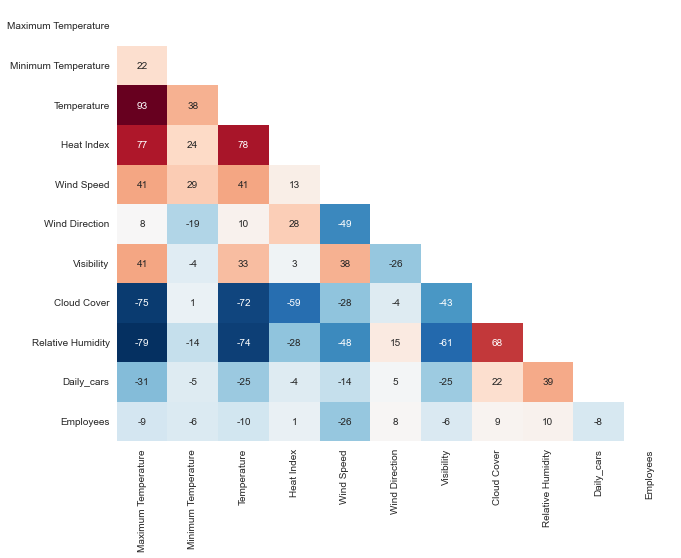

In [35]:
## Let's look again the correlation graph

## White background Chart
sns.set_style("whitegrid")

## Generate a mask for the upper triangle
mask = np.zeros_like(new_df.corr())
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(10,8))

sns.heatmap(new_df.corr() * 100, 
            cmap="RdBu_r", 
            annot=True, 
            fmt=".0f", 
            mask=mask,
            cbar=False
           )

plt.show()

* Temperature and Minimum Temperature -> Strong Positive Correlation
* Heat Index and Maximum Temperature -> Strong Positive Correlation
* Heat Index and Tempearature -> Strong Positive Correlation
* Cloud Cover and Maximum Temperature -> Stong Negative Correlation
* Cloud Cover and Minimum Temperature -> Strong Negative Correlation
* Relative Humidity and Maximum Temperature -> Strong Negative Correlation
* Relative Humidity and Temperature -> Strong Negative Correlation

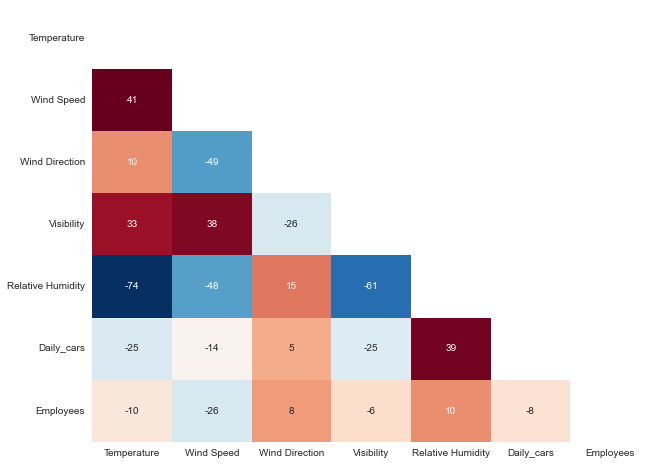

In [40]:
## Let drop fews features -> "Maximum Temperature", "Minimum Temperature", "Cloud Cover", "Heat Index"

new_df = new_df.drop(["Maximum Temperature", "Minimum Temperature", "Cloud Cover", "Heat Index"], axis=1)

## White background Chart
sns.set_style("whitegrid")

## Generate a mask for the upper triangle
mask = np.zeros_like(new_df.corr())
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(10,8))

sns.heatmap(new_df.corr() * 100, 
            cmap="RdBu_r", 
            annot=True, 
            fmt=".0f", 
            mask=mask,
            cbar=False
           )

plt.show()

The only correlation left is Temperature and Relative Humidity

### 3.5 Prepare Analytical Base Table

In [41]:
abt_df = pd.get_dummies(new_df, columns=["Weekday"])

abt_df

,Temperature,Wind Speed,Wind Direction,Visibility,Relative Humidity,Daily_cars,Employees,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,81.5,11.0,110.26,4.8,87.09,662,1030,0,0,0,0,0,1,0
1,82.8,9.7,133.13,5.3,80.42,669,1027,0,0,0,0,0,0,1
2,81.3,7.6,145.67,4.7,84.02,674,1006,0,0,0,0,1,0,0
3,81.0,8.1,101.43,5.2,84.76,634,999,1,0,0,0,0,0,0
4,82.0,7.7,118.73,5.3,81.24,610,122,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,82.8,9.2,104.67,4.2,80.79,626,1039,0,0,0,0,0,0,1
65,83.5,9.7,115.00,4.5,79.33,598,1050,0,0,0,0,1,0,0
66,83.9,11.4,134.75,4.2,77.01,633,1008,1,0,0,0,0,0,0
67,84.4,11.0,125.92,4.1,79.24,604,92,0,0,1,0,0,0,0


## 4.0 Algorithm Selection

We will use five algorithms for this project. Namely:

1. Lasso
2. Ridge
3. Elastic-Net
4. Random Forests
5. Boosted Trees

## 5.0 Model Selection

### 5.1 Split Your Dataset

In [42]:
## Let's show the analytical base table dataframe
abt_df.head()

,Temperature,Wind Speed,Wind Direction,Visibility,Relative Humidity,Daily_cars,Employees,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,81.5,11.0,110.26,4.8,87.09,662,1030,0,0,0,0,0,1,0
1,82.8,9.7,133.13,5.3,80.42,669,1027,0,0,0,0,0,0,1
2,81.3,7.6,145.67,4.7,84.02,674,1006,0,0,0,0,1,0,0
3,81.0,8.1,101.43,5.2,84.76,634,999,1,0,0,0,0,0,0
4,82.0,7.7,118.73,5.3,81.24,610,122,0,0,1,0,0,0,0


In [43]:
## Create separate object for target variable
y = abt_df["Daily_cars"]

## Create separate object for input features
X = abt_df.drop("Daily_cars", axis=1)

In [44]:
## Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)

print(len(X_train), len(X_test), len(y_train), len(y_test))

55 14 55 14


### 5.2 Build Model Pipelines

In [46]:
pipelines = {
    "lasso" : make_pipeline(StandardScaler(), Lasso(random_state=1234)),
    "ridge" : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    "enet" : make_pipeline(StandardScaler(), ElasticNet(random_state=1234)),
    "rf" : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    "gb" : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

### 5.3 Declare Hyperparameter Grids

In [47]:
### Use get_params() to find tubeable hyperparameters
pipelines["lasso"].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('lasso', Lasso(random_state=1234))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'lasso': Lasso(random_state=1234),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': 'deprecated',
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 1234,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [48]:
pipelines["gb"].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('gradientboostingregressor', GradientBoostingRegressor(random_state=123))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'gradientboostingregressor': GradientBoostingRegressor(random_state=123),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'gradientboostingregressor__alpha': 0.9,
 'gradientboostingregressor__ccp_alpha': 0.0,
 'gradientboostingregressor__criterion': 'friedman_mse',
 'gradientboostingregressor__init': None,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': None,
 'gradientboostingregressor__max_leaf_nodes': None,
 'gradientboostingregressor__min_impurity_decrease': 0.0,
 'gradientboostingregressor__min_samples_leaf': 1,
 'gradientboostingregressor__min_samples_split': 2,
 'gradientboostingregress

In [49]:
## Regularized Linear Regression hyperparameters tuning
lasso_hyperparameters = {
    "lasso__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

ridge_hyperparameters = {
    "ridge__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

enet_hyperparameters = {
    "elasticnet__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    "elasticnet__l1_ratio" : [0.1, 0.3, 0.5, 0.7, 0.9]
}

## Tree Ensemble hyperparameters tuning
rf_hyperparameters = {
    "randomforestregressor__n_estimators" : [100, 200],
    "randomforestregressor__max_features" : ["auto", "sqrt", "0.33"]
}

gb_hyperparameters = {
    "gradientboostingregressor__n_estimators" : [100, 200],
    "gradientboostingregressor__learning_rate" : [0.05, 0.1, 0.2],
    "gradientboostingregressor__max_depth" : [1, 3, 5]
}

In [50]:
## Create hyperparameters dictionary
hyperparameters = {
    "lasso" : lasso_hyperparameters,
    "ridge" : ridge_hyperparameters,
    "enet"  : enet_hyperparameters,
    "rf" : rf_hyperparameters,
    "gb" : gb_hyperparameters
}

In [51]:
## Finally run the code to check that hyperparameters is setup correctly
for key in ["lasso", "ridge", "enet", "rf", "gb"]:
    if key in hyperparameters:
        if type(hyperparameters[key] is dict):
            print(key, "was found in hyperparameters, and it is a grid.")
        else:
            print(key, "was found in hyperparameters, but it is not a grid.")
    else:
        print(key, "was not found in hyperparameters")

lasso was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
enet was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.


## 5.4 Fit and Tune Models with Cross Validation

In [ ]:
## Create empty dictionary for fitted model
fitted_model = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    
    fitted_model[name] = model
    
    print(name, "has been fitted")

In [53]:
## Check that we have 5 cross-validation objects
for key, value in fitted_model.items():
    print( key, type(value) )

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [54]:
## Check the model have been fitted correctly
from sklearn.exceptions import NotFittedError

for name, model in fitted_model.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


### 5.5 Cross Validated Training Performance

In [55]:
for name, model in fitted_model.items():
    print(name, model.best_score_)

lasso -3.854559514459112
ridge -5.221928874788792
enet -1.5588537019127329
rf -0.7907471939458635
gb -0.4807039263634124


### 5.6 R Squared and Mean Absolute Error

In [56]:
for name, model in fitted_model.items():
    pred = model.predict(X_test)
    print( name )
    print( '--------' )
    print( 'R^2:', r2_score(y_test, pred ))
    print( 'MAE:', mean_absolute_error(y_test, pred))
    print()

lasso
--------
R^2: -3.7091024552125864
MAE: 58.19011176968582

ridge
--------
R^2: -5.272071236582963
MAE: 74.32316126929179

enet
--------
R^2: -2.752785775062908
MAE: 52.0941083646876

rf
--------
R^2: -8.696203353635108
MAE: 77.78214285714286

gb
--------
R^2: -9.52498153517592
MAE: 82.14083306675263



**Next, ask yourself these questions to pick the winning model:** 

1. Which model had the highest R2 on the test set? **Elastic Net**
2. Which model had the lowest mean absolute error? **Ridge**
3. Are these two models the same one? **No**
4. Did it also have the best holdout R2 score from cross-validation? **For Elastic Net yes**
5. Does it satisfy our project's win condition? (Tip: In the event of ambiguous results based on the previous questions, THIS should be your final deciding factor on whether a model is "good enough.") **Maybe**

### 5.7 Actual Value vs Predicted Value

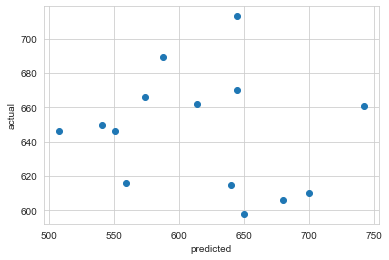

In [70]:
## Ridge
ridge_pred = fitted_model["ridge"].predict(X_test)
plt.scatter(ridge_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

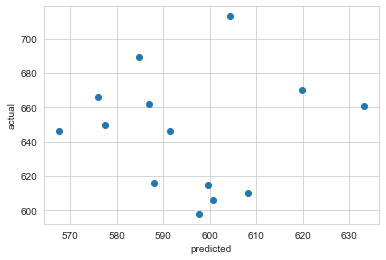

In [72]:
## Enet
enet_pred = fitted_model["enet"].predict(X_test)
plt.scatter(enet_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

## 6.0 Insight & Analysis

**There is two best model for this prediction - Ridge and Elastic Net**

However, the performance of the models are average as the data is less (< 100 rows). In the other hands, feature engineering and hyperparameter need to be tuned around to increase the accuracy of the model.

(There R squared negative value means the model actually not following the trend of data)

My next plan will be:
1. Increase the amount data in the dataset
2. Setup deployment web application Django to production.